In [2]:
import torch
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/Atari/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import random
%matplotlib inline

# 手写版本

# 1.1 Data Prepare

In [11]:
W = torch.tensor([2, -3.4])
b = torch.tensor([4.2])
X = torch.normal(0, 1, (1000, len(W)))
y = torch.matmul(X, W) + b
y += torch.normal(0, 0.01, y.shape)

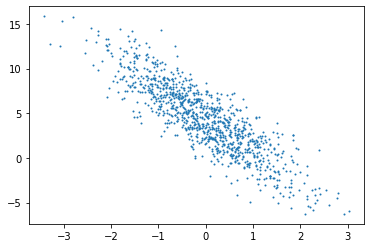

In [16]:
plt.scatter(X[:,1].detach().numpy(), y.detach().numpy(), 1);

# 1.2 读取数据

In [20]:
def data_iter(batch_size):
    num_example = len(X)
    indices = list(range(num_example))
    random.shuffle(indices)
    for i in range(0, num_example, batch_size):
        batch_indices = torch.tensor(indices[i:min(batch_size+i, num_example)])
        yield X[batch_indices], y[batch_indices]
    

In [23]:
# batch 意思是每10个数字为一个batch
batch_size = 10
for features, labels in data_iter(batch_size):
    print(features, labels)
    break

tensor([[ 0.2598, -0.6283],
        [-1.2725,  0.2428],
        [-0.4889, -1.0941],
        [ 1.4163, -1.5842],
        [-1.3020, -0.6739],
        [ 1.6102, -0.2134],
        [-0.1532,  1.0732],
        [ 1.0155,  0.2546],
        [ 0.7895,  1.2200],
        [ 1.1110, -1.4666]]) tensor([ 6.8406,  0.8139,  6.9523, 12.4256,  3.8957,  8.1272,  0.2362,  5.3804,
         1.6342, 11.4055])


# 1.3 初始化模型参数

In [24]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 1.4 定义模型

In [25]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 1.5 定义损失函数

In [26]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

# 1.6 定义优化算法

In [27]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 1.7 train

In [28]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [29]:
for epoch in range(num_epochs):
    for X_train, y_train in data_iter(batch_size):
        l = loss(net(X_train, w, b), y_train)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(X,w,b), y)
        print(train_l.mean())

tensor(0.0264)
tensor(9.3530e-05)
tensor(5.2218e-05)


In [30]:
print(w, b)

tensor([[ 2.0001],
        [-3.3997]], requires_grad=True) tensor([4.1995], requires_grad=True)


# 使用库函数的实现版本

In [32]:
import numpy as np
import torch
from torch.utils import data

## 2.1 生成并使用dataloader倒入数据

In [44]:
true_w = torch.tensor([2.0, -3.4])
true_b = 4.2

In [45]:
def synthetic_data(true_w, true_b, data_size):
    X = torch.normal(0, 1, (data_size, len(true_w)))
    y = torch.matmul(X, true_w) + true_b
    y += torch.normal(0, 0.01, y.shape)
    return X, y

features, labels = synthetic_data(true_w, true_b, 1000)

In [46]:
def load_array(data_arrays, batch_size, is_train=True): # is_train means data shuffle
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [47]:
batch_size = 10
data_iter = load_array((features, labels), batch_size, True)

In [48]:
next(iter(data_iter))

[tensor([[ 1.4040,  0.4971],
         [ 0.7033, -0.2282],
         [ 0.7912, -1.0671],
         [ 0.5141,  0.0930],
         [-0.3760,  1.6009],
         [-1.8390, -1.2004],
         [ 0.4514, -0.3786],
         [ 0.2482, -1.6291],
         [ 1.7194,  0.1574],
         [-0.3304,  0.9755]]),
 tensor([ 5.3103,  6.3804,  9.4155,  4.9252, -2.0031,  4.5881,  6.3757, 10.2338,
          7.1096,  0.2068])]

## 2.2 定义模型

In [50]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [80]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [77]:
loss = nn.MSELoss()

In [81]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 2.3 train

In [82]:
num_epochs = 10
print(f'before: w: {net[0].weight.data} b: {net[0].bias.data}')
print(f'w: {true_w.data} b: {true_b}')

for epoch in range(num_epochs):
    for X, y in data_iter:
        predict_y = net(X)
        l = loss(predict_y, y.reshape(predict_y.shape))
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)   
    print(f'loss {l:f}')
    print(f'w: {net[0].weight.data} b: {net[0].bias.data}')


before: w: tensor([[ 0.0024, -0.0027]]) b: tensor([0.])
w: tensor([ 2.0000, -3.4000]) b: 4.2
loss 31.292372
w: tensor([[ 1.9987, -3.3920]]) b: tensor([4.1925])
loss 31.345295
w: tensor([[ 1.9986, -3.3999]]) b: tensor([4.2005])
loss 31.350313
w: tensor([[ 1.9998, -3.3999]]) b: tensor([4.1998])
loss 31.352173
w: tensor([[ 2.0003, -3.3999]]) b: tensor([4.2003])
loss 31.348251
w: tensor([[ 1.9995, -3.3998]]) b: tensor([4.2003])
loss 31.356215
w: tensor([[ 2.0003, -3.4005]]) b: tensor([4.2000])
loss 31.344576
w: tensor([[ 1.9999, -3.3990]]) b: tensor([4.2003])
loss 31.345840
w: tensor([[ 1.9992, -3.3996]]) b: tensor([4.2000])
loss 31.351299
w: tensor([[ 2.0002, -3.3998]]) b: tensor([4.2000])
loss 31.347553
w: tensor([[ 1.9996, -3.3996]]) b: tensor([4.2007])
